In [39]:
from zeep import Client
import pandas as pd
import matplotlib.pyplot as plt

# Initialize client to gather SNOTEL info

In [40]:
wsdl_url = "https://wcc.sc.egov.usda.gov/awdbWebService/services?WSDL"
client = Client(wsdl_url)

# Retrieve metadata

In [41]:
metadata = client.service.getStations(logicalAnd=True)

# Query data for Mores Creek SNOTEL site

In [42]:
mores_creek_triplet = "637:ID:SNTL"

# Define water year: October 1, 2023 through September 30, 2024

In [43]:
import datetime
start_date = datetime.date(2023, 10, 1)
end_date = datetime.date(2024, 9, 30)

# Retrieve daily SWE data

In [44]:
response = client.service.getData(
    mores_creek_triplet, 
    elementCd='WTEQ',      # Element code for Snow Water Equivalent
    ordinal=1,             # Adding the ordinal parameter
    duration='DAILY',
    getFlags=False,
    beginDate=start_date.isoformat(),
    endDate=end_date.isoformat(),
    alwaysReturnDailyFeb29=False
    )

# Parse the SOAP records into a pandas DataFrame

In [45]:
records = []
for station_data in response:
    # Get the begin date from the data object
    begin_dt_str = station_data['beginDate'] # get the begin date string
    begin_dt = pd.to_datetime(begin_dt_str) # convert to datetime object
    
    # Loop through the values list. Each value corresponds to a consecutive day.
    for i, value in enumerate(station_data['values']):
        records.append({
            'station_triplet': station_data['stationTriplet'],
            'date': begin_dt + pd.Timedelta(days=i),
            'value': value
        })

df = pd.DataFrame(records) # Create a DataFrame from the records list
df.set_index("date", inplace=True) # Set the date column as the index

# Clean the data

In [46]:
print(df.head())
print(df.info())
print(df.describe())


           station_triplet value
date                            
2023-10-01     637:ID:SNTL   0.0
2023-10-02     637:ID:SNTL   0.0
2023-10-03     637:ID:SNTL   0.0
2023-10-04     637:ID:SNTL   0.0
2023-10-05     637:ID:SNTL   0.0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2023-10-01 to 2024-09-30
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   station_triplet  366 non-null    object
 1   value            366 non-null    object
dtypes: object(2)
memory usage: 8.6+ KB
None
       station_triplet value
count              366   366
unique               1    91
top        637:ID:SNTL   0.0
freq               366   176


In [47]:
# Convert the 'value' column to a numeric type (float)
df["value"] = pd.to_numeric(df["value"])
print(df.info())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 366 entries, 2023-10-01 to 2024-09-30
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   station_triplet  366 non-null    object 
 1   value            366 non-null    float64
dtypes: float64(1), object(1)
memory usage: 8.6+ KB
None


# Basic SWE visualization

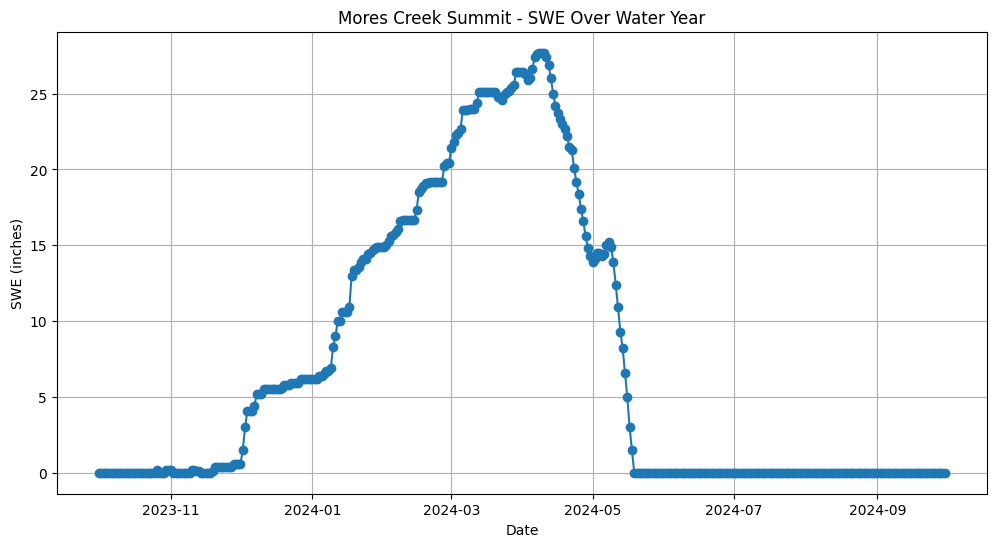

In [48]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["value"], marker='o', linestyle='-')
plt.title("Mores Creek Summit - SWE Over Water Year")
plt.xlabel("Date")
plt.ylabel("SWE (inches)")
plt.grid(True)
plt.show()

# Calculate daily change

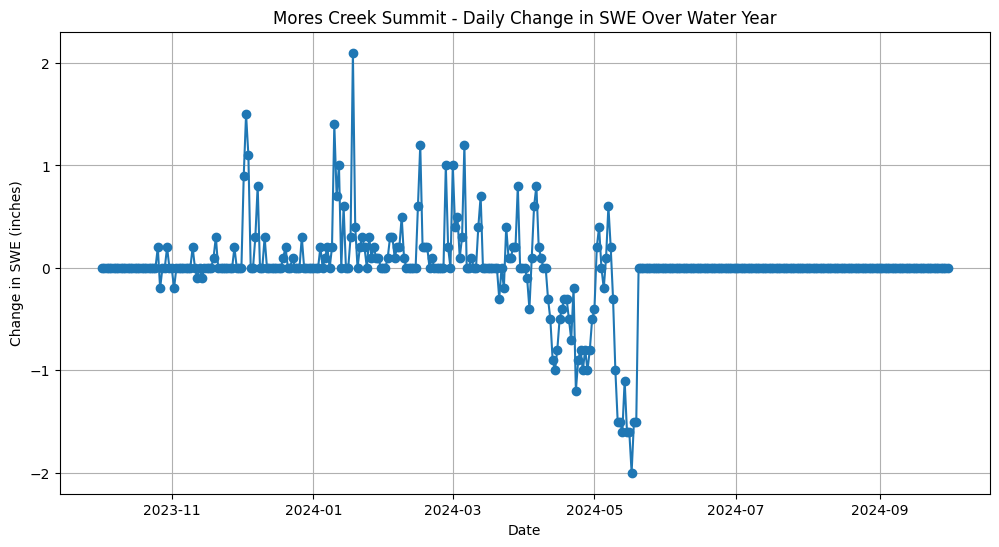

In [49]:
df["daily_change"] = df["value"].diff()
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["daily_change"], marker='o', linestyle='-')
plt.title("Mores Creek Summit - Daily Change in SWE Over Water Year")
plt.xlabel("Date")
plt.ylabel("Change in SWE (inches)")
plt.grid(True)
plt.show()

# Cumulative accumulation over the water year

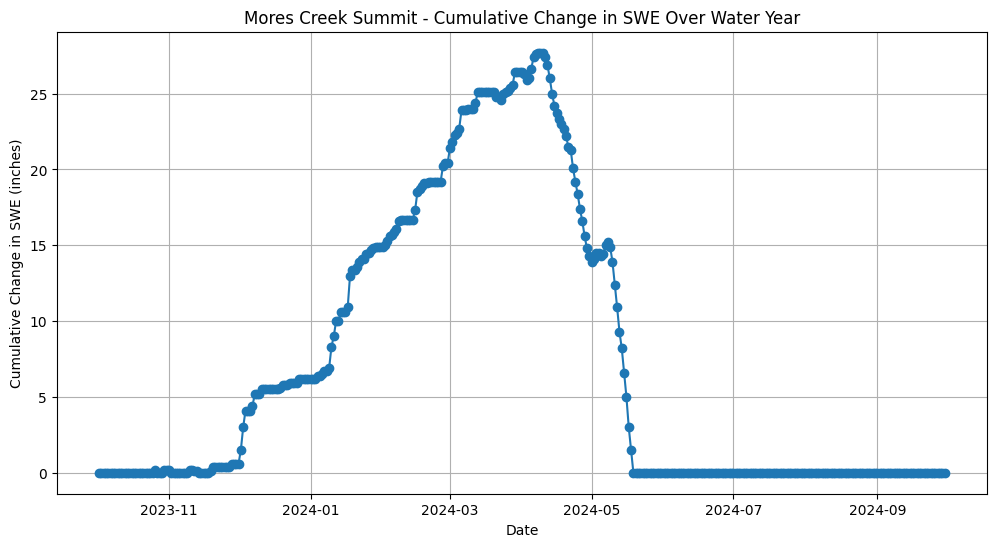

In [50]:
df["cummulative_change"] = df["value"].diff().cumsum()
plt.figure(figsize=(12, 6))
plt.plot(df.index, df["cummulative_change"], marker='o', linestyle='-')
plt.title("Mores Creek Summit - Cumulative Change in SWE Over Water Year")
plt.xlabel("Date")
plt.ylabel("Cumulative Change in SWE (inches)")
plt.grid(True)
plt.show()
